# Task B: Meta-Learning Perfomance Prediction

In this task, you will use learning curves and metadata on multiple OpenML dataset to train a performance predictor that performs well even for unseen datasets. You are provided with learning curves, config parameters and metafeatures for six datasets. The datasets are split into training datasets and test datasets and you should only train on the training datasets. Also, you should only use the first 10 epochs of the learning curves in your predictions.

__Note: This notebook showcases the use of the API for dataloading. You can change the dataloading and splitting as long as you only use the first 10 epochs of the curves for predicting and do not train on the test datasets.__

## Specifications:

* Data: six_datasets_lw.json
* Number of datasets: 6
* Training datasets: higgs, vehicle, adult, volkert
* Test datasets: Fashion-MNIST, jasmine
* Number of configurations: 2000
* Number of epochs seen when predicting: 10
* Available data: Learning curves, architecture parameters and hyperparameters, metafeatures 
* Target: Final validation accuracy
* Evaluation metric: MSE

## Importing and splitting data

Note: There are 51 steps logged, 50 epochs plus the 0th epoch, prior to any weight updates.

In [1]:
%%capture
%cd ..
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from api import Benchmark

In [2]:
bench_dir = "cached/six_datasets_lw.json"
bench = Benchmark(bench_dir, cache=False)

==> Loading data...
==> No cached data found or cache set to False.
==> Reading json data...
==> Done.


In [3]:
with open("cached/metafeatures.json", "r") as f:
    metafeatures = json.load(f)

In [4]:
# Dataset split
dataset_names = bench.get_dataset_names()
print(dataset_names)

train_datasets = ['adult', 'higgs', 'vehicle', 'volkert']
test_datasets = ['Fashion-MNIST', 'jasmine']

['Fashion-MNIST', 'adult', 'higgs', 'jasmine', 'vehicle', 'volkert']


In [5]:
# Prepare data
def read_data(datasets):
    n_configs = bench.get_number_of_configs(datasets[0])
    data = [bench.query(dataset_name=d, tag="Train/val_accuracy", config_id=ind) for d in datasets for ind in range(n_configs)]
    configs = [bench.query(dataset_name=d, tag="config", config_id=ind) for d in datasets for ind in range(n_configs)]
    dataset_names = [d for d in datasets for ind in range(n_configs)]
    
    X = np.array([curve[:-1] for curve in data])
    y = np.array([curve[-1] for curve in data])
    return X, y, np.array(configs), np.array(dataset_names)

class TrainValSplitter():
    """Splits 30 % data as a validation split."""
    
    def __init__(self, dataset_names):
        self.ind_train, self.ind_val = train_test_split(np.arange(len(X)), test_size=0.3, stratify=dataset_names)
        
    def split(self, a):
        return a[self.ind_train], a[self.ind_val]
    
    def cut(self, a, outlength=11):
        return np.array([curve[:outlength] for curve in a])

X, y, configs, dataset_names = read_data(train_datasets)
X_test, y_test, configs_test, dataset_names_test = read_data(test_datasets)

tv_splitter = TrainValSplitter(dataset_names=dataset_names)

X_train, X_val = tv_splitter.split(X)
y_train, y_val = tv_splitter.split(y)
configs_train, configs_val = tv_splitter.split(configs)
dataset_names_train, dataset_names_val = tv_splitter.split(configs)

X_test, X_val = tv_splitter.cut(X_test), tv_splitter.cut(X_val)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("X_val:", X_val.shape)

X_train: (5600, 51)
X_test: (4000, 11)
X_val: (2400, 11)


The data contains the configuration of the trained model and learning curves.

__Note__: Not all parameters vary across different configurations. The varying parameters are batch_size, max_dropout, max_units, num_layers, learning_rate, momentum, weight_decay

In [6]:
# Config
print("Config example:", configs_train[0])

Config example: {'batch_size': 384, 'imputation_strategy': 'mean', 'learning_rate_scheduler': 'cosine_annealing', 'loss': 'cross_entropy_weighted', 'network': 'shapedmlpnet', 'max_dropout': 0.7395812913604772, 'normalization_strategy': 'standardize', 'optimizer': 'sgd', 'cosine_annealing_T_max': 50, 'cosine_annealing_eta_min': 1e-08, 'activation': 'relu', 'max_units': 64, 'mlp_shape': 'funnel', 'num_layers': 3, 'learning_rate': 0.00996803786436224, 'momentum': 0.23630874651789913, 'weight_decay': 0.021629793946234824}


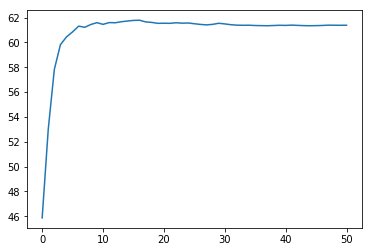

In [7]:
# Learning curve
plt.plot(X_train[1])

In [8]:
# Metafeatures
for key,val in metafeatures["adult"].items():
    print(" : ".join([key, str(val)]))

AutoCorrelation : 0.634425994553756
ClassEntropy : 0.7938438393644257
Dimensionality : 0.00030711273084640267
EquivalentNumberOfAtts : 11.068507517484338
MajorityClassPercentage : 76.07182343065395
MajorityClassSize : 37155.0
MaxAttributeEntropy : 3.44192266924963
MaxKurtosisOfNumericAtts : 152.69309629815925
MaxMeansOfNumericAtts : 189664.13459727284
MaxMutualInformation : 0.16542318099233
MaxNominalAttDistinctValues : 41.0
MaxSkewnessOfNumericAtts : 11.89465899659272
MaxStdDevOfNumericAtts : 105604.02542315713
MeanAttributeEntropy : 1.7809891200338273
MeanKurtosisOfNumericAtts : 30.359637681213712
MeanMeansOfNumericAtts : 31819.974765570616
MeanMutualInformation : 0.0717209468494675
MeanNoiseToSignalRatio : 23.832203118732952
MeanNominalAttDistinctValues : 11.222222222222221
MeanSkewnessOfNumericAtts : 3.063860808334838
MeanStdDevOfNumericAtts : 18914.620326608216
MinAttributeEntropy : 0.795215031650176
MinKurtosisOfNumericAtts : -0.18426874062378573
MinMeansOfNumericAtts : 10.078088

## A simple baseline

In [9]:
class SimpleLearningCurvePredictor():
    """A learning curve predictor that predicts the last observed epoch as final performance"""
    
    def __init__(self):
        pass
        
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        predictions = []
        for curve in X:
            predictions.append(curve[-1])
        return predictions
    
def score(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

In [10]:
# Train and validate
predictor = SimpleLearningCurvePredictor()
predictor.fit(X_train, y_train)
preds = predictor.predict(X_val)
mse = score(y_val, preds)
print(mse)

28.393642996705086


In [11]:
# Final evaluation
final_preds = predictor.predict(X_test)
final_score = score(y_test, final_preds)
print("Final test score:", final_score)

Final test score: 35.521812191401985
